<a href="https://colab.research.google.com/github/CarlTeapot/Walmart-Recruiting/blob/main/model_expreiment_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlflow==2.2.2

In [2]:
!pip install kaggle

In [3]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.9 MB/s eta 0:00:00


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"giorgitoronjadze","key":"9c4aebca47b5575e27b4c70560a74ddf"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!pip install opendatasets
!pip install dagshub

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
import os
from sklearn.model_selection import TimeSeriesSplit
import pickle

In [8]:
import opendatasets as od
od.download("https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/overview")

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [9]:

# 1. Load the datasets
train = pd.read_csv('/content/walmart-recruiting-store-sales-forecasting/train.csv.zip')  # Store, Dept, Date, Weekly_Sales, IsHoliday
features = pd.read_csv('/content/walmart-recruiting-store-sales-forecasting/features.csv.zip')  # Store, Date, Temperature, Fuel_Price, CPI, Unemployment, IsHoliday
stores = pd.read_csv('/content/walmart-recruiting-store-sales-forecasting/stores.csv')  # Store, Type, Size

# 2. Inspect columns
print("Train columns:", train.columns.tolist())
print("Features columns:", features.columns.tolist())
print("Stores columns:", stores.columns.tolist())

# 3. Preprocess dates
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
features['Date'] = pd.to_datetime(features['Date'], format='%Y-%m-%d')

# 4. Merge datasets
# Merge train with features on Store and Date
data = train.merge(features, on=['Store', 'Date'], how='left').merge(stores, on='Store', how='left')
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Store', 'Dept', 'Date'])

print(data.head())

# 5. Handle 'IsHoliday' column to avoid "['IsHoliday'] not in index"
# if 'IsHoliday_features' in merged.columns:
#     merged['IsHoliday'] = merged['IsHoliday'].fillna(merged['IsHoliday_features'])
#     merged = merged.drop(columns=['IsHoliday_features'])
# else:
#     if 'IsHoliday' not in merged.columns:
#         print("Warning: 'IsHoliday' column missing. Creating default column with False.")
#         merged['IsHoliday'] = False
# merged['IsHoliday'] = merged['IsHoliday'].astype(bool)

# 6. Handle missing values
# for col in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']:
#     if col in merged.columns:
#         merged[col] = merged.groupby('Store')[col].transform(lambda x: x.fillna(x.median()))
#         merged[col] = merged[col].fillna(merged[col].median())
# if 'Type' in merged.columns:
#     merged['Type'] = merged['Type'].fillna(merged['Type'].mode()[0])

# 7. Feature engineering
# merged['Year'] = merged['Date'].dt.year
# merged['Month'] = merged['Date'].dt.month
# merged['Week'] = merged['Date'].dt.isocalendar().week
# merged['DayOfMonth'] = merged['Date'].dt.day
# merged = merged.sort_values(['Store', 'Dept', 'Date'])
# merged['Lag1_Sales'] = merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
# merged['Lag2_Sales'] = merged.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)

# 8. Resample data by month for each Store-Dept combination
# resampled_data = []
# min_rows = 10  # Minimum number of rows after resampling to avoid "Insufficient data"

# for (store, dept), group in merged.groupby(['Store', 'Dept']):
#     try:
#         # Set Date as index for resampling
#         group = group.set_index('Date')
#         # Resample to monthly frequency, taking mean for numerical columns
#         monthly_data = group[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
#                               'Size', 'Year', 'Month', 'Week', 'DayOfMonth',
#                               'Lag1_Sales', 'Lag2_Sales']].resample('MS').mean()
#         # Handle IsHoliday (True if any week in the month is a holiday)
#         is_holiday = group['IsHoliday'].resample('MS').max().astype(bool)
#         monthly_data['IsHoliday'] = is_holiday
#         # Add Store and Dept columns
#         monthly_data['Store'] = store
#         monthly_data['Dept'] = dept
#         # Reset index to make Date a column
#         monthly_data = monthly_data.reset_index()
#         # Check for sufficient data
#         if len(monthly_data) < min_rows:
#             print(f"Skipping Store {store}, Dept {dept}: Insufficient data ({len(monthly_data)} rows after resampling)")
#             continue
#         resampled_data.append(monthly_data)
#     except Exception as e:
#         print(f"Failed resampling for Store {store}, Dept {dept}: {str(e)}")
#         continue

# # 9. Concatenate resampled data
# if resampled_data:
#     model_data = pd.concat(resampled_data, ignore_index=True)
# else:
#     print("No valid data after resampling. Check data or preprocessing steps.")
#     raise ValueError("No objects to concatenate")

# # 10. Save preprocessed data
# model_data.to_csv('preprocessed_monthly_data.csv', index=False)
# print("Preprocessed monthly data saved to 'preprocessed_monthly_data.csv'")

# # 11. Train-test split and plotting for each Store-Dept
# predictions_all = []
# for (store, dept), group in model_data.groupby(['Store', 'Dept']):
#     try:
#         # Ensure Date is index for time series
#         group = group.set_index('Date')
#         # Train-test split (70% train, 30% test)
#         train_size = int(0.7 * len(group))
#         train_data = group.iloc[:train_size][['Weekly_Sales', 'IsHoliday']]
#         test_data = group.iloc[train_size:][['Weekly_Sales', 'IsHoliday']]

#         # Check for sufficient data
#         if len(train_data) < min_rows or len(test_data) < 1:
#             print(f"Skipping Store {store}, Dept {dept}: Insufficient train/test data (Train: {len(train_data)}, Test: {len(test_data)})")
#             continue

#         # Plot train and test data
#         plt.figure(figsize=(20, 8))
#         train_data['Weekly_Sales'].plot(label='Train Weekly Sales')
#         test_data['Weekly_Sales'].plot(label='Test Weekly Sales')
#         plt.title(f'Weekly Sales for Store {store}, Dept {dept}', fontsize=14)
#         plt.xlabel('Date')
#         plt.ylabel('Weekly Sales')
#         plt.legend()
#         plt.show()

#         # Prepare data for ARIMA/SARIMAX
#         train_sales = train_data['Weekly_Sales']
#         test_sales = test_data['Weekly_Sales']
#         train_exog = train_data[['IsHoliday']]  # Exogenous variable for SARIMAX
#         test_exog = test_data[['IsHoliday']]

#         # Placeholder for model predictions (replace with ARIMA/SARIMAX)
#         # Example: from statsmodels.tsa.statespace.sarimax import SARIMAX
#         # model = SARIMAX(train_sales, exog=train_exog, order=(1,1,1), seasonal_order=(1,1,1,12))
#         # prediction = model.fit().forecast(steps=len(test_data), exog=test_exog)
#         prediction = [0] * len(test_data)  # Replace with actual predictions

#         # Store predictions
#         prediction_df = pd.DataFrame({
#             'Store': store,
#             'Dept': dept,
#             'Date': test_data.index,
#             'Prediction': prediction
#         })
#         predictions_all.append(prediction_df)

#     except Exception as e:
#         print(f"Failed for Store {store}, Dept {dept}: {str(e)}")
#         continue

# # 12. Save predictions
# if predictions_all:
#     submission = pd.concat(predictions_all)
#     submission.to_csv('submission.csv', index=False)
#     print("Predictions saved to 'submission.csv'")
# else:
#     print("No predictions generated. Check data or logic.")

# # 13. Check Store 45, Dept 91-98 specifically
# print("\nChecking Store 45, Departments 91-98:")
# for dept in range(91, 99):
#     store_dept_data = model_data[(model_data['Store'] == 45) & (model_data['Dept'] == dept)]
#     row_count = len(store_dept_data)
#     has_is_holiday = 'IsHoliday' in store_dept_data.columns
#     print(f"Store 45, Dept {dept}: {row_count} rows, IsHoliday present: {has_is_holiday}")
#     if row_count > 0:
#         print(f"  Sample data:\n{store_dept_data[['Date', 'Weekly_Sales', 'IsHoliday']].head().to_string()}")
#     if row_count < min_rows:
#         print(f"  Warning: Insufficient data for Store 45, Dept {dept} ({row_count} rows)")

Train columns: ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']
Features columns: ['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']
Stores columns: ['Store', 'Type', 'Size']
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN       

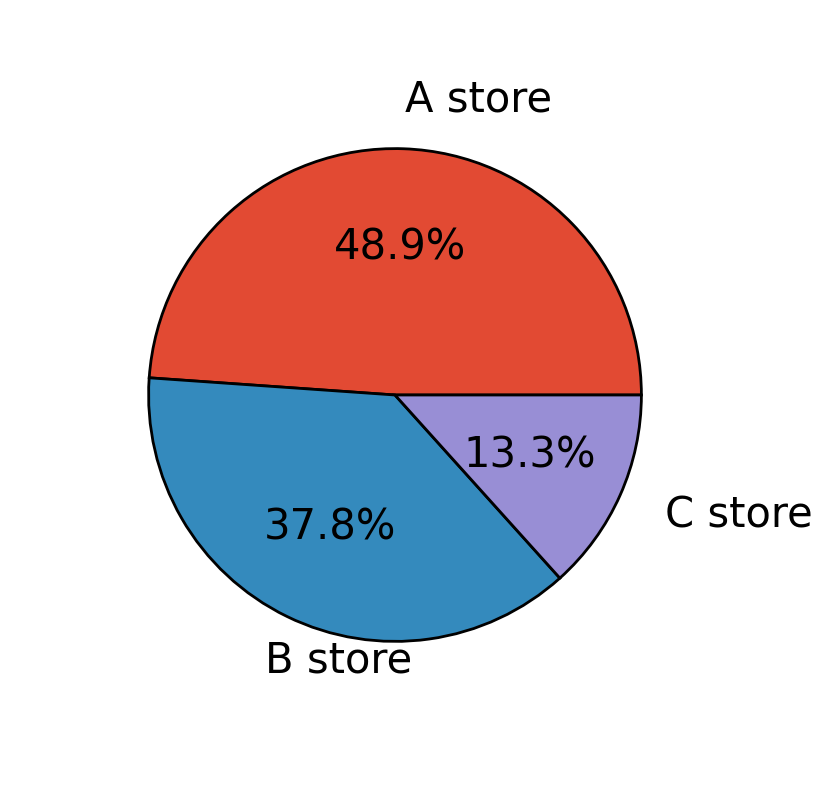

In [10]:
sorted_type = stores.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
wprops={'edgecolor':'black',
      'linewidth':2}
tprops = {'fontsize':30}
axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

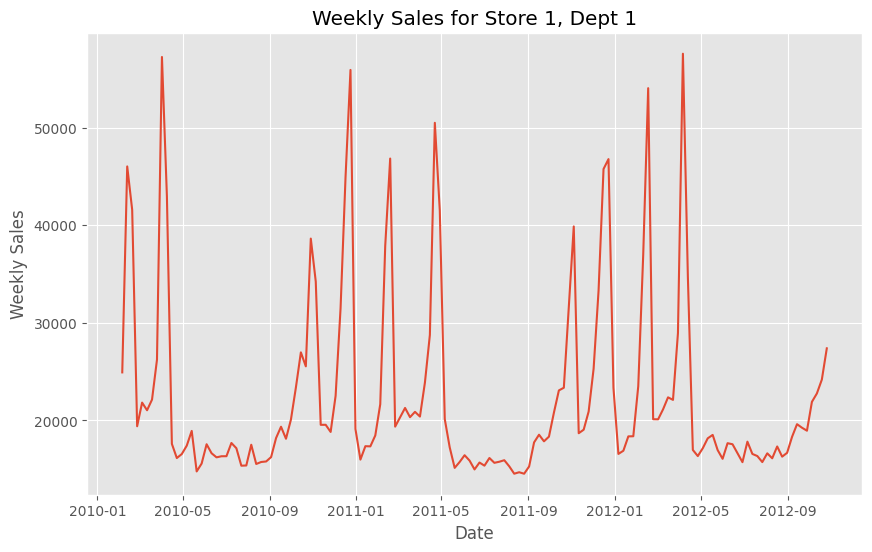

ADF Statistic: -2.5221638686500367
p-value: 0.11017432282586997
Series is not stationary


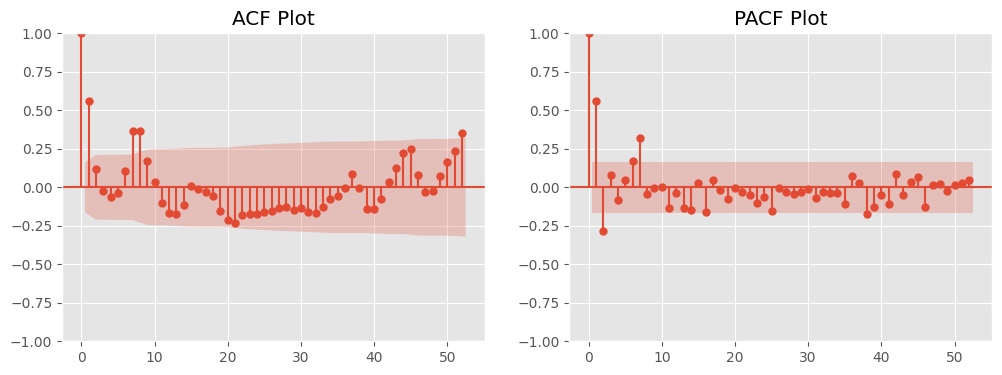

In [11]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot sales for a sample Store-Department
sample_data = train[(train['Store'] == 1) & (train['Dept'] == 1)]
plt.figure(figsize=(10, 6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'])
plt.title('Weekly Sales for Store 1, Dept 1')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print('Series is stationary')
    else:
        print('Series is not stationary')

check_stationarity(sample_data['Weekly_Sales'])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plot_acf(sample_data['Weekly_Sales'], lags=52, ax=plt.gca())
plt.title('ACF Plot')
plt.subplot(122)
plot_pacf(sample_data['Weekly_Sales'], lags=52, ax=plt.gca())
plt.title('PACF Plot')
plt.show()

In [12]:
import numpy
print(numpy.__version__)

1.26.4


In [13]:
# !pip uninstall numpy pmdarima -y
# !pip install numpy==1.24.3 pmdarima==2.0.4

In [14]:
# Check for missing values
print(data.isnull().sum())

# Basic statistics
print(data.describe())

# Check stationarity (simplified, for one store-dept)
from statsmodels.tsa.stattools import adfuller
sample_series = data[(data['Store'] == 1) & (data['Dept'] == 1)]['Weekly_Sales']
result = adfuller(sample_series.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64
               Store           Dept                           Date  \
count  421570.000000  421570.000000                         421570   
mean       22.200546      44.260317  2011-06-18 08:30:31.963375104   
min         1.000000       1.000000            2010-02-05 00:00:00   
25%        11.000000      18.000000            2010-10-08 00:00:00   
50%        22.000000      37.000000            2011-06-17 00:00:00   
75%        33.000000      74.000000            2012-02-24 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.785297      30.492054 

In [15]:
class TimeSeriesPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Handle missing values
        X = X.copy()
        X['MarkDown1'].fillna(0, inplace=True)
        X['MarkDown2'].fillna(0, inplace=True)
        X['MarkDown3'].fillna(0, inplace=True)
        X['MarkDown4'].fillna(0, inplace=True)
        X['MarkDown5'].fillna(0, inplace=True)
        X['CPI'].fillna(X['CPI'].mean(), inplace=True)
        X['Unemployment'].fillna(X['Unemployment'].mean(), inplace=True)

        # Ensure date is datetime
        X['Date'] = pd.to_datetime(X['Date'])
        return X

# Apply preprocessing
preprocessor = TimeSeriesPreprocessor()
data_processed = preprocessor.fit_transform(data)

# # Save processed data
# data_processed.to_csv('../data/processed/train_processed.csv', index=False)

/tmp/ipython-input-15-1365753677.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['MarkDown1'].fillna(0, inplace=True)
/tmp/ipython-input-15-1365753677.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [16]:
print(data_processed.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size'],
      dtype='object')


In [17]:
print(data_processed[['IsHoliday_x', 'IsHoliday_y']].head())
print(data_processed['IsHoliday_x'].equals(data_processed['IsHoliday_y']))

   IsHoliday_x  IsHoliday_y
0        False        False
1         True         True
2        False        False
3        False        False
4        False        False
True


In [18]:
def create_features(df):
    df = df.copy()
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['Is_Holiday'] = df['IsHoliday_y'].astype(int)
    return df

data_processed = create_features(data_processed)

In [22]:
from pmdarima import auto_arima

class ARIMAModel(BaseEstimator):
    def __init__(self):
        self.models = {}

    def fit(self, X, y=None):
        for (store, dept), group in X.groupby(['Store', 'Dept']):
            series = group['Weekly_Sales'].dropna()
            if len(series) > 10:
                try:
                    model = auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True)
                    self.models[(store, dept)] = model
                except:
                    print(f'Failed to fit ARIMA for Store {store}, Dept {dept}')
        return self

    def predict(self, X):
        predictions = []
        for (store, dept), group in X.groupby(['Store', 'Dept']):
            model = self.models.get((store, dept))
            if model is not None:
                pred = model.predict(n_periods=len(group))
                predictions.extend(list(zip(group['Date'], pred)))
            else:
                predictions.extend(list(zip(group['Date'], [group['Weekly_Sales'].mean()] * len(group))))
        pred_df = pd.DataFrame(predictions, columns=['Date', 'Weekly_Sales'])
        return pred_df

from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessor', TimeSeriesPreprocessor()),
    ('model', ARIMAModel())
])

In [23]:
import dagshub
dagshub.init(repo_owner='CarlTeapot', repo_name='Walmart-Recruiting', mlflow=True)

Initialized MLflow to track repo "CarlTeapot/Walmart-Recruiting"

Repository CarlTeapot/Walmart-Recruiting initialized!

In [ ]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []

mlflow.set_experiment('ARIMA_Training')

with mlflow.start_run(run_name='ARIMA_CrossValidation'):
    for train_idx, val_idx in tscv.split(data_processed):
        train_data = data_processed.iloc[train_idx]
        val_data = data_processed.iloc[val_idx]

        # Fit pipeline
        pipeline.fit(train_data)

        # Predict
        pred_df = pipeline.predict(val_data)

        # Merge predictions with actuals
        val_data = val_data.merge(pred_df, on='Date', suffixes=('', '_pred'))

        # Calculate metrics
        rmse = mean_squared_error(val_data['Weekly_Sales'], val_data['Weekly_Sales_pred'], squared=False)
        mae = mean_absolute_error(val_data['Weekly_Sales'], val_data['Weekly_Sales_pred'])

        rmse_scores.append(rmse)
        mae_scores.append(mae)

        # Log metrics
        mlflow.log_metric('rmse', rmse)
        mlflow.log_metric('mae', mae)

    # Log average metrics
    mlflow.log_metric('avg_rmse', np.mean(rmse_scores))
    mlflow.log_metric('avg_mae', np.mean(mae_scores))
    print(f'Average RMSE: {np.mean(rmse_scores):.2f}')
    print(f'Average MAE: {np.mean(mae_scores):.2f}')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed

In [ ]:
with mlflow.start_run(run_name='ARIMA_Final_Model'):
    # Fit pipeline on full data
    pipeline.fit(data_processed)

    # Save pipeline
    with open('../models/model_ARIMA_pipeline.pkl', 'wb') as f:
        pickle.dump(pipeline, f)

    # Log pipeline to MLflow
    mlflow.sklearn.log_model(pipeline, 'arima_pipeline')

    # Log parameters
    mlflow.log_param('arima_order', (1, 1, 1))

    print('ARIMA pipeline saved to ../models/model_ARIMA_pipeline.pkl')